In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

Loading DATA

In [2]:


def load_data(file):
    mdro = pd.read_excel(file, sheet_name='MDROs', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
    report = pd.read_excel(file, sheet_name='微生物報告', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
    info = pd.read_excel(file, sheet_name='就醫資訊', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
    anti = pd.read_excel(file, sheet_name='抗生素使用', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
    examValue = pd.read_excel(file, sheet_name='檢驗數值', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
    
    # data processing 
    mdro = mdro[['病歷號碼', 'time', '就醫序號','申請編號', '菌株', '預測值', '部位', 'sendTime']]
    mdro.rename({'time':'openTime'}, axis=1, inplace=True)
    
    report = report[['病歷號碼', 'bed', '就醫序號','申請編號', 'strain','部位', '抗藥性菌株', 'examTime','reportTime']]
    
    cdss = pd.merge(report, mdro, how='left', on=['病歷號碼', '就醫序號','申請編號', '部位'])
    cdss = cdss.drop_duplicates()
    cdss['minTime'] = cdss.groupby(['病歷號碼', 'bed','就醫序號', '申請編號', '部位', '菌株', '預測值',  'sendTime'])['openTime'].transform('min')
    
    info = info[['病歷號碼', '就醫序號', '性別', '生日', '年齡', '來院日期', '離院日期', '天數', '門急住', '科別代碼', '科別']]
    info.rename({'門急住':'bed'}, axis=1, inplace=True)
    
    cdss_info = pd.merge(cdss, info, how='left', on=['病歷號碼', '就醫序號', 'bed'])
    cdss_info = cdss_info.drop_duplicates()
    
    CDSS = pd.merge(cdss_info, anti, how='left', on=['病歷號碼','就醫序號'])
    CDSS = CDSS.drop_duplicates()
    
    
    return CDSS
    

In [3]:
# 智抗菌平台報表_20220331.xlsx

file = r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx'
CDSS = load_data(file)
CDSS.head(10)

,病歷號碼,bed,就醫序號,申請編號,strain,部位,抗藥性菌株,examTime,reportTime,openTime,...,科別,類別,醫令代碼,每次量,途徑,頻率,使用天數,開始時間,截止時間,囑咐
0,0024072616,門診,162535324,393554401,[嗜氧] Escherichia coli (Gram Negative Bacilli)\...,UC,1.0,2020-11-18 10:37,2020-11-20 14:15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0013338420,門診,166169183,393597787,[嗜氧] Escherichia coli (Gram Negative Bacilli)\...,UM,NaN,2020-11-20 08:14,2020-11-23 11:56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000347929,門診,165821017,393588973,[嗜氧] Klebsiella variicola (Gram Negative Bacilli),UM,NaN,2020-11-27 16:37,2020-11-30 11:03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0036736549,住院,168863479,393626399,[嗜氧] Enterococcus gallinarum (Gram Positive Co...,DP,NaN,2020-12-05 13:36,2020-12-11 07:47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0036736549,住院,168863479,393626401,[嗜氧] Bacillus cereus (Gram Positive Bacilli),DP,NaN,2020-12-05 13:36,2020-12-11 07:47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0012182642,急診,168908064,393627309,[血液] Klebsiella pneumoniae (Gram Negative Baci...,B,1.0,2020-12-07 13:17,2020-12-11 08:29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0018495723,急診,168943781,393629167,[血液] Staphylococcus capitis (Gram Positive Coc...,B,NaN,2020-12-09 13:19,2020-12-11 11:29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0000597208,門診,168938959,393629479,[嗜氧] Pseudomonas aeruginosa (Gram Negative Bac...,UC,NaN,2020-12-09 15:40,2020-12-11 12:36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0000984145,住院,168918238,393627638,[嗜氧] Escherichia coli (Gram Negative Bacilli)\...,UM,NaN,2020-12-08 07:44,2020-12-11 13:14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0000034825,住院,168906377,393629161,[嗜氧] Corynebacterium striatum (Gram Positive B...,SCO,NaN,2020-12-09 10:38,2020-12-11 13:26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# mdro

In [5]:
# load data

mdro = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx', sheet_name='MDROs', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
report = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx', sheet_name='微生物報告', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})
info = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx', sheet_name='就醫資訊', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
anti = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx', sheet_name='抗生素使用', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})
examValue = pd.read_excel(r'C:\Users\User\VSCode\智抗菌平台報表_20220331.xlsx', sheet_name='檢驗數值', 
                        dtype={'病歷號碼':'str', '就醫序號':'int'})



Exception ignored in: <function ZipFile.__del__ at 0x00000207A9699700>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\zipfile.py", line 1821, in __del__
    self.close()
KeyboardInterrupt: 


In [ ]:
# load data 2021
report2021 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='微生物報告', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})

CMT250 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='CMT250', 
                        dtype={'病歷號':'str', '申請編號':'int', '就醫序號':'int'})

examValue2021 = pd.read_excel(r'C:\Users\User\VSCode\data_2021.xlsx', sheet_name='檢驗數值', 
                        dtype={'病歷號碼':'str', '申請編號':'int', '就醫序號':'int'})



In [ ]:
mdro = mdro[['病歷號碼', 'time', '就醫序號','申請編號', '菌株', '預測值', '部位', 'sendTime']]
mdro.rename({'time':'openTime'}, axis=1, inplace=True)

In [ ]:
report = report[['病歷號碼', 'bed', '就醫序號','申請編號', 'strain','部位', '抗藥性菌株', 'examTime','reportTime']]

In [ ]:
cdss = pd.merge(report, mdro, how='left', on=['病歷號碼', '就醫序號','申請編號', '部位'])
cdss = cdss.drop_duplicates()
cdss['minTime'] = cdss.groupby(['病歷號碼', 'bed','就醫序號', '申請編號', '部位', '菌株', '預測值',  'sendTime'])['openTime'].transform('min')

In [ ]:
info = info[['病歷號碼', '就醫序號', '性別', '生日', '年齡', '來院日期', '離院日期', '天數', '門急住', '科別代碼', '科別']]
info.rename({'門急住':'bed'}, axis=1, inplace=True)

In [ ]:
cdss_info = pd.merge(cdss, info, how='left', on=['病歷號碼', '就醫序號', 'bed'])
cdss_info = cdss_info.drop_duplicates()

In [ ]:
CDSS = pd.merge(cdss_info, anti, how='left', on=['病歷號碼','就醫序號'])
CDSS = CDSS.drop_duplicates()

In [ ]:
CDSS_old = pd.read_excel(r'C:\Users\User\VSCode\CDSS(2022).xlsx')
CDSS = pd.concat([CDSS_old, CDSS])
CDSS = CDSS.drop_duplicates()

In [ ]:
# CDSS.to_excel(r'C:\Users\User\VSCode\CDSS(20220401).xlsx')

In [ ]:
# evaluation

m = CDSS[CDSS.openTime==CDSS.minTime]

Strain

Acinetobacter baumannii

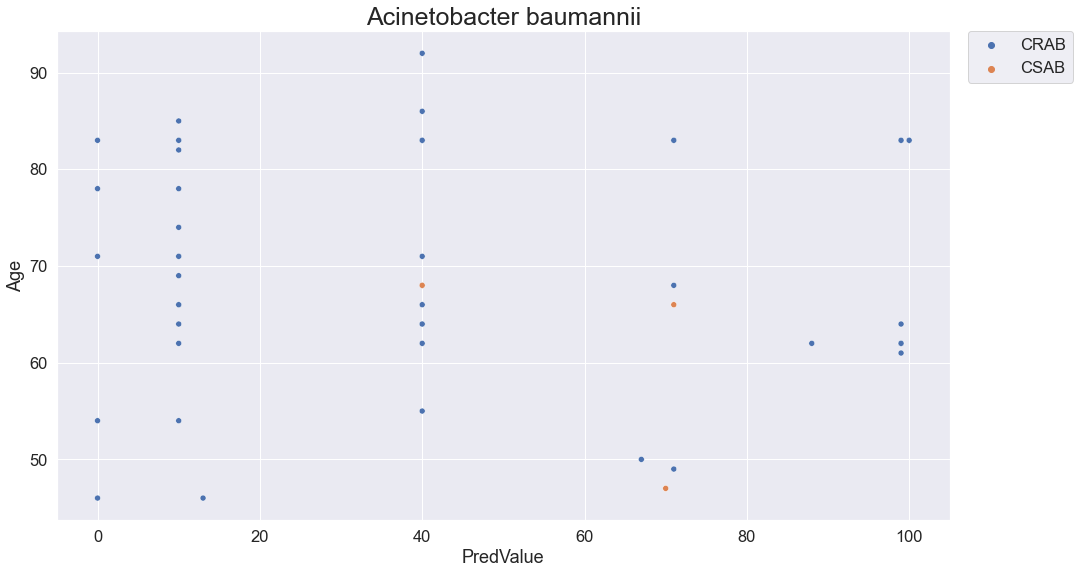

Strain: Acinetobacter baumannii
Amount: 149
Patient: 90

                  Resist
PredLevel Resist        
0~20%     CRAB        92
          CSAB         9
21~40%    CRAB        22
          CSAB         2
41~60%    CRAB         2
61~80%    CRAB         5
          CSAB         2
81~100%   CRAB        15


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,101.0,9.435644,3.198174,0.0,10.00,10.0,10.0,17.0
21~40%,24.0,33.000000,8.091864,21.0,25.25,38.5,40.0,40.0
41~60%,2.0,42.000000,1.414214,41.0,41.50,42.0,42.5,43.0
61~80%,7.0,70.285714,1.496026,67.0,70.50,71.0,71.0,71.0
81~100%,15.0,98.666667,2.992053,88.0,99.00,99.0,100.0,100.0


In [ ]:
# Acinetobacter baumannii

AB = m[(m['菌株'] == 'Acinetobacter baumannii')|(m['菌株'] == 'Acinetobacter baumannii/calcoaceticus complex')]
AB = AB.drop_duplicates() 

AB = AB[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #100
AB['STRAIN'] = 'Acinetobacter baumannii'

# add column 'predValue interval'
AB_condition = [(AB['預測值'] <= 20), (AB['預測值'] > 20)&(AB['預測值'] <= 40), 
             (AB['預測值'] > 40)&(AB['預測值'] <= 60), (AB['預測值'] > 60)&(AB['預測值'] <= 80),
             (AB['預測值'] > 80)&(AB['預測值'] <= 100)]

AB_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
AB['PredLevel'] = np.select(AB_condition, AB_value)

# add column 'Resistance'
AB['Resist'] = np.where(AB['抗藥性菌株']==1, 'CRAB', 'CSAB')
AB.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Acinetobacter baumannii', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=AB, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Acinetobacter baumannii')
print('Amount:', AB['病歷號碼'].count())
print('Patient:', AB['病歷號碼'].drop_duplicates().count())
print()
print(pd.DataFrame(AB.groupby('PredLevel')['Resist'].value_counts().sort_index()))
AB.groupby('PredLevel')['PredValue'].describe()


Staphylococcus aureus

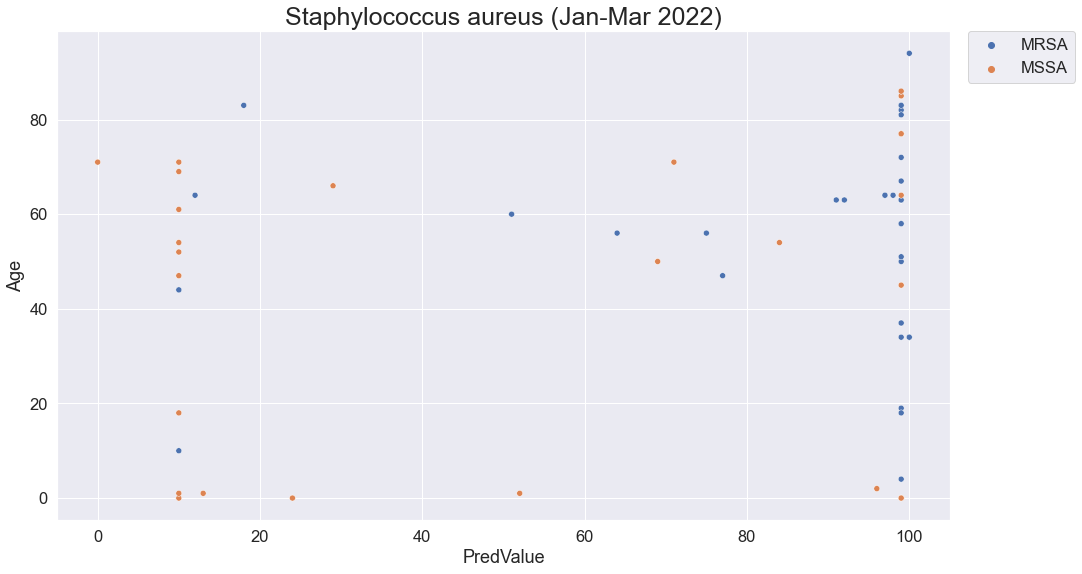

Predicted  MRSA  MSSA
Actual               
MRSA         84    26
MSSA         16    44


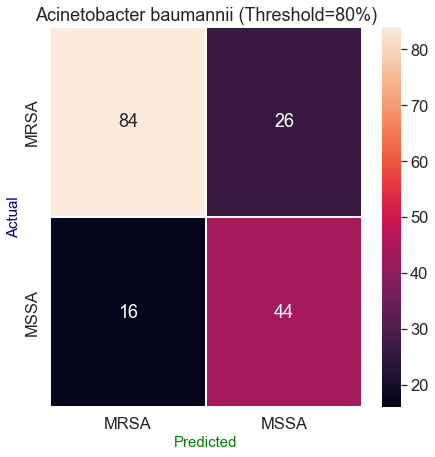

Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 170
Patient: 110

PredLevel  Resist
0~20%      MRSA      16
           MSSA      35
21~40%     MRSA       2
           MSSA       2
41~60%     MRSA       2
           MSSA       2
61~80%     MRSA       6
           MSSA       5
81~100%    MRSA      84
           MSSA      16
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,51.0,9.039216,4.454035,0.0,10.00,10.0,10.00,19.0
21~40%,4.0,26.750000,4.573474,22.0,23.50,26.5,29.75,32.0
41~60%,4.0,55.250000,4.425306,51.0,51.75,55.0,58.50,60.0
61~80%,11.0,73.181818,5.963525,64.0,68.00,75.0,78.00,80.0
81~100%,100.0,98.220000,3.236721,84.0,99.00,99.0,100.00,100.0


In [ ]:
# Staphylococcus aureus

SA = m[(m['菌株'] == 'Staphylococcus aureus')|(m['菌株'] == 'Staphylococcus aureus(MRSA)')]
SA = SA.drop_duplicates() 

SA = SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
SA['STRAIN'] = 'Staphylococcus aureus'

# add column 'predValue interval'
condition = [(SA['預測值'] <= 20), (SA['預測值'] > 20)&(SA['預測值'] <= 40), 
             (SA['預測值'] > 40)&(SA['預測值'] <= 60), (SA['預測值'] > 60)&(SA['預測值'] <= 80),
             (SA['預測值'] > 80)&(SA['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
SA['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
SA['Resist'] = np.where(SA['抗藥性菌株']==1, 'MRSA', 'MSSA')
SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()

# confusion matrix
SA['TH60'] = np.where(SA.PredValue>60, 'MRSA', 'MSSA')
SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
plt.title('Acinetobacter baumannii (Threshold=80%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



Escherichia coli

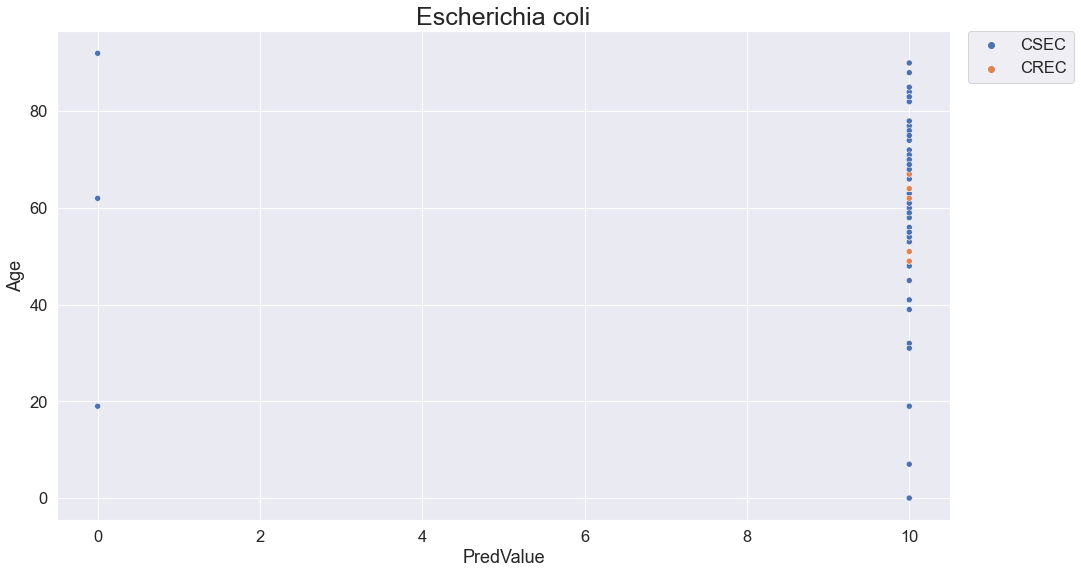

Strain: Escherichia coli
Amount: 196
Patient: 157

PredLevel  Resist
0~20%      CREC       24
           CSEC      172
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,196.0,9.234694,2.66526,0.0,10.0,10.0,10.0,10.0


In [ ]:
# Escherichia coli

EC = m[(m['菌株'] == 'Escherichia coli')]
EC = EC.drop_duplicates() 

EC = EC[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() 
EC['STRAIN'] = 'Escherichia coli'

# add column 'predValue interval'
EC_condition = [(EC['預測值'] <= 20), (EC['預測值'] > 20)&(EC['預測值'] <= 40), 
             (EC['預測值'] > 40)&(EC['預測值'] <= 60), (EC['預測值'] > 60)&(EC['預測值'] <= 80),
             (EC['預測值'] > 80)&(EC['預測值'] <= 100)]

EC_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
EC['PredLevel'] = np.select(EC_condition, EC_value)

# add column 'Resistance'
EC['Resist'] = np.where(EC['抗藥性菌株']==1, 'CREC', 'CSEC')
EC.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Escherichia coli', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=EC, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Escherichia coli')
print('Amount:', EC['病歷號碼'].count())
print('Patient:', EC['病歷號碼'].drop_duplicates().count())
print()
print(EC.groupby('PredLevel')['Resist'].value_counts().sort_index())
EC.groupby('PredLevel')['PredValue'].describe()




Pseudomonas aeruginosa

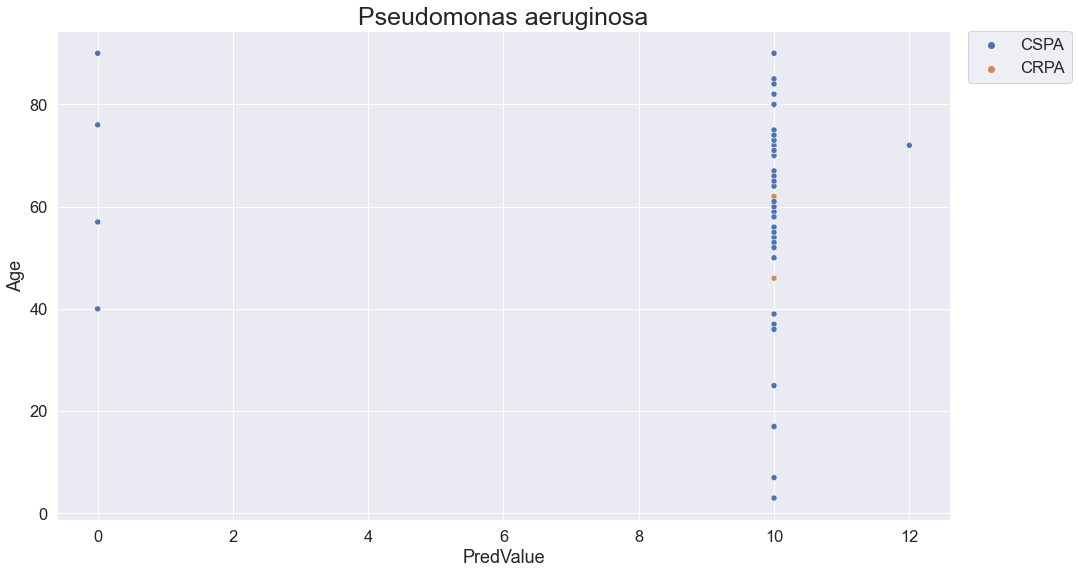

Strain: Pseudomonas aeruginosa
Amount: 168
Patient: 131

PredLevel  Resist
0~20%      CRPA       23
           CSPA      145
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,168.0,9.380952,2.514174,0.0,10.0,10.0,10.0,14.0


In [ ]:
# Pseudomonas aeruginosa

PA = m[(m['菌株'] == 'Pseudomonas aeruginosa')]
PA = PA.drop_duplicates() 

PA = PA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #107
PA['STRAIN'] = 'Pseudomonas aeruginosa'

# add column 'predValue interval'
PA_condition = [(PA['預測值'] <= 20), (PA['預測值'] > 20)&(PA['預測值'] <= 40), 
             (PA['預測值'] > 40)&(PA['預測值'] <= 60), (PA['預測值'] > 60)&(PA['預測值'] <= 80),
             (PA['預測值'] > 80)&(PA['預測值'] <= 100)]

PA_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
PA['PredLevel'] = np.select(PA_condition, PA_value)

# add column 'Resistance'
PA['Resist'] = np.where(PA['抗藥性菌株']==1, 'CRPA', 'CSPA')
PA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Pseudomonas aeruginosa', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=PA, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Pseudomonas aeruginosa')
print('Amount:', PA['病歷號碼'].count())
print('Patient:', PA['病歷號碼'].drop_duplicates().count())
print()
print(PA.groupby('PredLevel')['Resist'].value_counts().sort_index())
PA.groupby('PredLevel')['PredValue'].describe()


Klebsiella pneumoniae

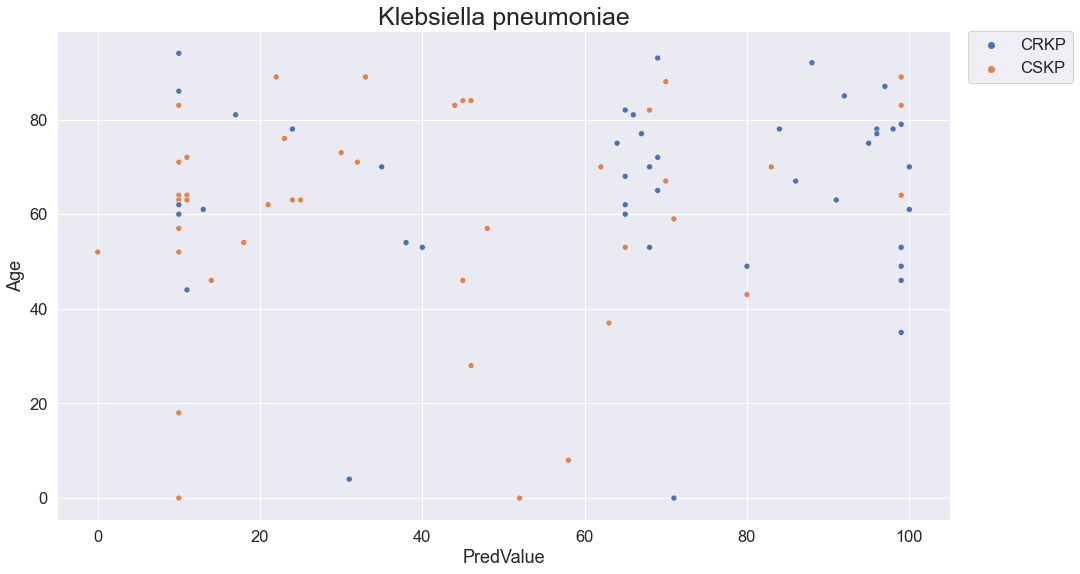

Strain: Klebsiella pneumoniae
Amount: 233
Patient: 171

PredLevel  Resist
0~20%      CRKP      61
           CSKP      54
21~40%     CRKP       9
           CSKP      14
41~60%     CRKP       2
           CSKP      10
61~80%     CRKP      23
           CSKP      11
81~100%    CRKP      44
           CSKP       5
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,115.0,9.330435,3.696185,0.0,10.0,10.0,10.00,19.0
21~40%,23.0,29.043478,6.101254,21.0,23.0,31.0,33.00,40.0
41~60%,12.0,48.333333,4.849242,41.0,45.0,47.0,52.00,58.0
61~80%,34.0,68.147059,4.207730,62.0,65.0,68.0,69.75,80.0
81~100%,49.0,95.734694,5.422851,83.0,94.0,99.0,100.00,100.0


In [ ]:
# Klebsiella pneumoniae

KP = m[(m['菌株'] == 'Klebsiella pneumoniae')]
KP = KP.drop_duplicates() 

KP = KP[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #141
KP['STRAIN'] = 'Klebsiella pneumoniae'

# add column 'predValue interval'
KP_condition = [(KP['預測值'] <= 20), (KP['預測值'] > 20)&(KP['預測值'] <= 40), 
             (KP['預測值'] > 40)&(KP['預測值'] <= 60), (KP['預測值'] > 60)&(KP['預測值'] <= 80),
             (KP['預測值'] > 80)&(KP['預測值'] <= 100)]

KP_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
KP['PredLevel'] = np.select(KP_condition, KP_value)

# add column 'Resistance'
KP['Resist'] = np.where(KP['抗藥性菌株']==1, 'CRKP', 'CSKP')
KP.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Klebsiella pneumoniae', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=KP, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()



# distribution
print('Strain: Klebsiella pneumoniae')
print('Amount:', KP['病歷號碼'].count())
print('Patient:', KP['病歷號碼'].drop_duplicates().count())
print()
print(KP.groupby('PredLevel')['Resist'].value_counts().sort_index())
KP.groupby('PredLevel')['PredValue'].describe()


Morganella morganii

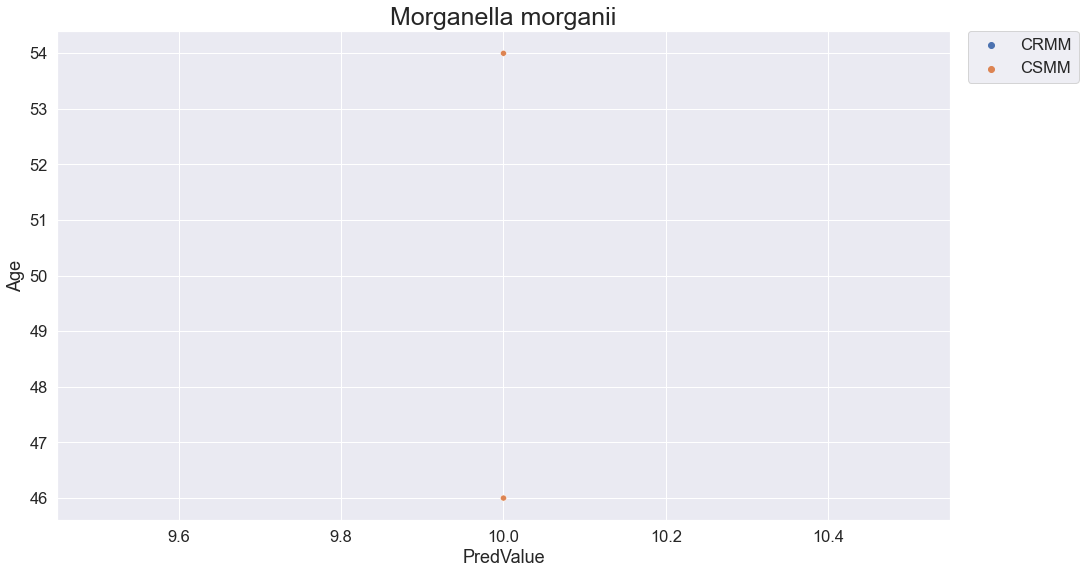

Strain: Morganella morganii
Amount: 9
Patient: 8

PredLevel  Resist
0~20%      CRMM      1
           CSMM      8
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,9.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0


In [ ]:
# Morganella morganii

MM = m[(m['菌株'] == 'Morganella morganii')]
MM = MM.drop_duplicates() 

MM = MM[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #141
MM['STRAIN'] = 'Morganella morganii'

# add column 'predValue interval'
MM_condition = [(MM['預測值'] <= 20), (MM['預測值'] > 20)&(MM['預測值'] <= 40), 
             (MM['預測值'] > 40)&(MM['預測值'] <= 60), (MM['預測值'] > 60)&(MM['預測值'] <= 80),
             (MM['預測值'] > 80)&(MM['預測值'] <= 100)]

MM_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
MM['PredLevel'] = np.select(MM_condition, MM_value)

# add column 'Resistance'
MM['Resist'] = np.where(MM['抗藥性菌株']==1, 'CRMM', 'CSMM')
MM.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)


# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Morganella morganii', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=MM, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Morganella morganii')
print('Amount:', MM['病歷號碼'].count())
print('Patient:', MM['病歷號碼'].drop_duplicates().count())
print()
print(MM.groupby('PredLevel')['Resist'].value_counts().sort_index())
MM.groupby('PredLevel')['PredValue'].describe()


Enterococcus faecium

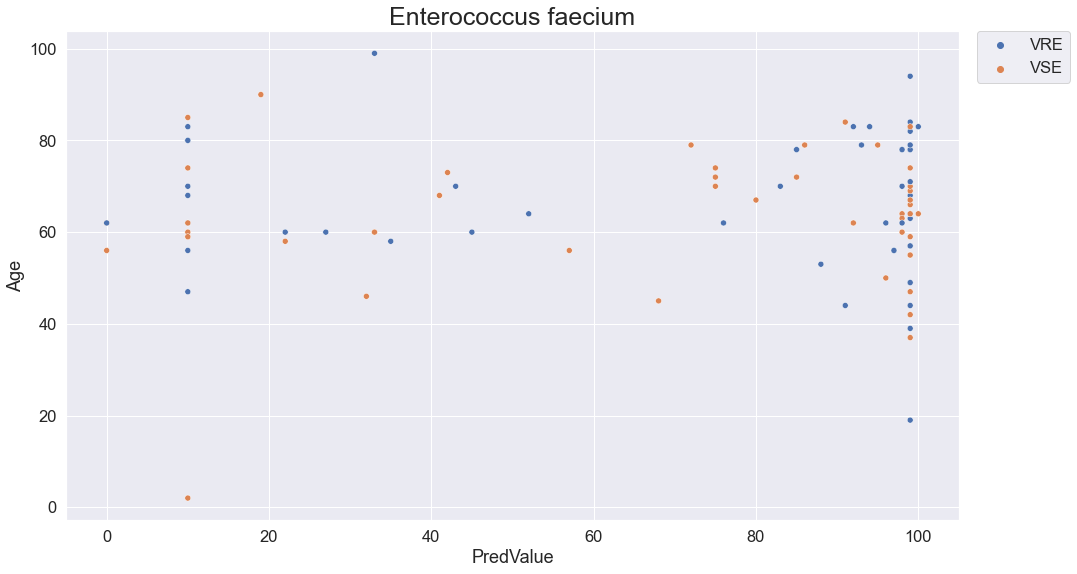

Strain: Enterococcus faecium
Amount: 253
Patient: 181

PredLevel  Resist
0~20%      VRE        24
           VSE        18
21~40%     VRE         7
           VSE         7
41~60%     VRE         8
           VSE         5
61~80%     VRE         1
           VSE         8
81~100%    VRE       121
           VSE        54
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,42.0,7.119048,5.789824,0.0,0.0,10.0,10.0,19.0
21~40%,14.0,30.500000,5.971084,22.0,25.5,32.0,34.5,40.0
41~60%,13.0,47.692308,6.088029,41.0,43.0,45.0,52.0,57.0
61~80%,9.0,72.666667,5.477226,61.0,72.0,75.0,75.0,80.0
81~100%,175.0,97.560000,4.168243,81.0,98.0,99.0,100.0,100.0


In [ ]:
# Enterococcus faecium
EF = m[(m['菌株'].isin(['Enterococcus faecium(VRE)', 'Enterococcus faecium', 'Enterococcus faecalis']))]
EF = EF.drop_duplicates() 

EF = EF[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #141
EF['STRAIN'] = 'Enterococcus faecium'

# add column 'predValue interval'
EF_condition = [(EF['預測值'] <= 20), (EF['預測值'] > 20)&(EF['預測值'] <= 40), 
             (EF['預測值'] > 40)&(EF['預測值'] <= 60), (EF['預測值'] > 60)&(EF['預測值'] <= 80),
             (EF['預測值'] > 80)&(EF['預測值'] <= 100)]

EF_value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
EF['PredLevel'] = np.select(EF_condition, EF_value)

# add column 'Resistance'
EF['Resist'] = np.where(EF['抗藥性菌株']==1, 'VRE', 'VSE')
EF.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Enterococcus faecium', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=EF, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()



# distribution
print('Strain: Enterococcus faecium')
print('Amount:', EF['病歷號碼'].count())
print('Patient:', EF['病歷號碼'].drop_duplicates().count())
print()
print(EF.groupby('PredLevel')['Resist'].value_counts().sort_index())
EF.groupby('PredLevel')['PredValue'].describe()


In [ ]:
# # scatter plot

# plt.figure(figsize=(16, 9))
# sn.set(font_scale = 1.5)
# plt.title('Escherichia coli', fontsize = 25)
# # Acinetobacter baumannii   AB  CRAB    CSAB
# # Staphylococcus aureus     SA	MRSA	MSSA
# # Escherichia coli          EC	CREC	CSEC
# # Pseudomonas aeruginosa    PA	CRPA	CSPA
# # Klebsiella pneumoniae     KP	CRKP	CSKP
# # Morganella morganii       MM	CRMM	CSMM
# # Enterococcus faecium      EF	VRE		VSE

# ax = sn.scatterplot(data=AB, x="PredValue", y="Age", hue="Resist")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# # plt.legend(loc='upper right')
# # sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

# plt.show()

In [ ]:
# print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
# SA.groupby('PredLevel')['PredValue'].describe()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


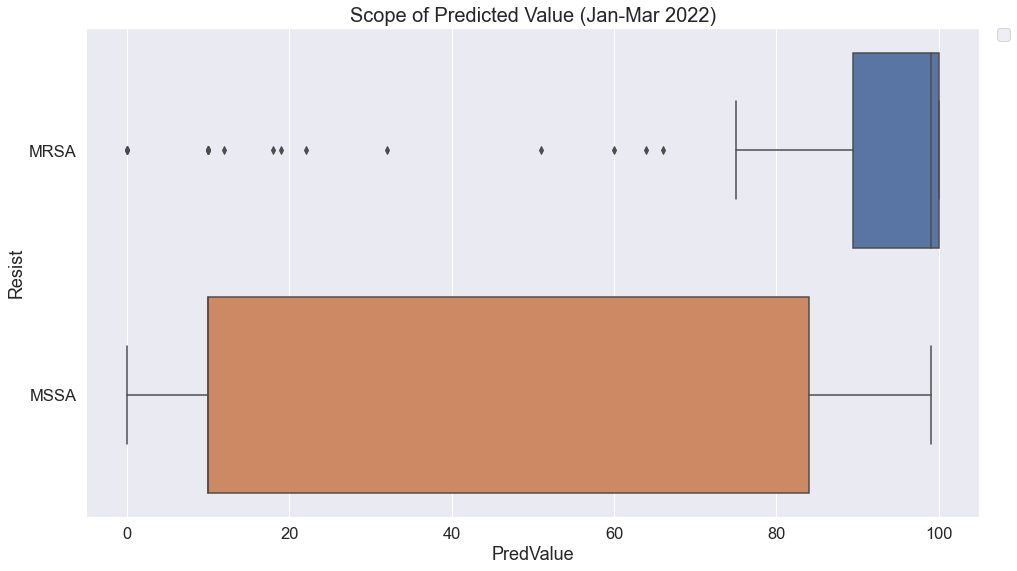

In [ ]:
plt.figure(figsize=(16,9))

hue_order = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
sn.boxplot(y='Resist', x='PredValue', orient='h', data=SA)#, hue='PredLevel', hue_order=hue_order, palette="Set3")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title('Scope of Predicted Value (Jan-Mar 2022)', fontsize = 20)
plt.show()

In [ ]:


# C_pred = [(SA['菌株'] == 'Staphylo
# coccus aureus'), (SA['菌株'] == 'Staphylococcus aureus(MRSA)')]
# V_pred = ['MSSA', 'MRSA']

# C_act = [(SA['抗藥性菌株']!=1), (SA['抗藥性菌株']==1)]
# V_act = ['MSSA', 'MRSA']

# SA['SA_pred'] = np.select(C_pred, V_pred)
# SA['SA_actual'] = np.select(C_act, V_act)
# SA['Group'] = 'Staphylococcus aureus'
# SA.head() 


# SA['Actual'] = np.where(SA['Resist'] == 'MRSA', 1, 0) 


Predicted  MRSA  MSSA
Actual               
MRSA         90    20
MSSA         21    39


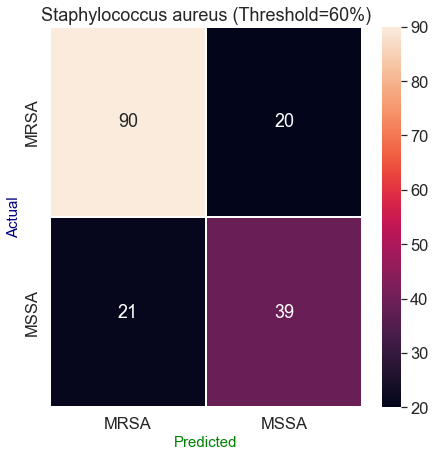

In [ ]:
# confusion matrix

# SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MRSA', 'MSSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['TH60'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
plt.title('Staphylococcus aureus (Threshold=60%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

In [ ]:
# box plot (pred value range)

# SA_1 = SA[(SA.SA_pred=='True')&(SA.SA_actual=='True')][['菌株', '預測值', 'Group']]
# SA_0 = SA[(SA.SA_pred!='True')&(SA.SA_actual!='True')][['菌株', '預測值', 'Group']]
# SA_1_0 = pd.concat([SA_1, SA_0])
# SA_1_0.rename({'菌株':'strain', '預測值':'pred_value'}, axis=1, inplace=True)

# SA_1_0.groupby('strain').describe()

In [ ]:
# plt.figure(figsize=(6,4))
# sn.boxplot(y='strain', x='pred_value', orient='h', data=SA_1_0, palette="Set3")
# plt.title('Scope of Predicted Value', fontsize = 15)
# plt.show()

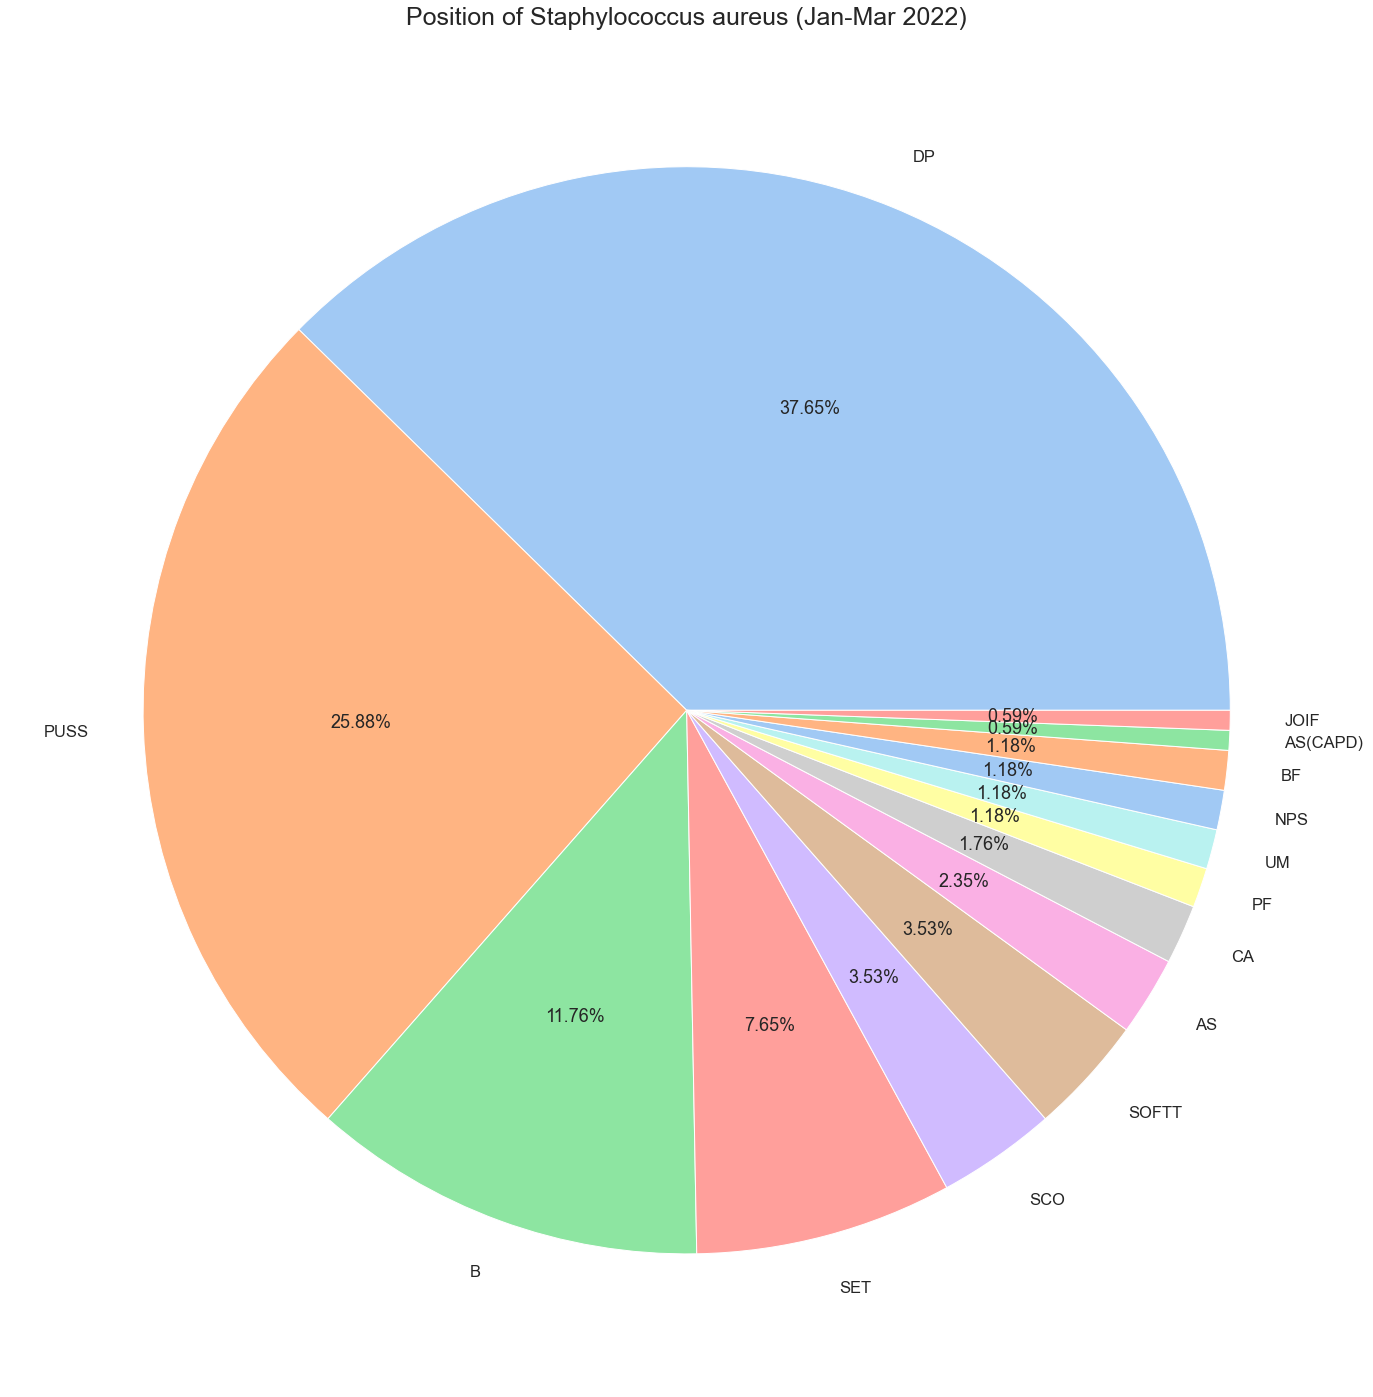

In [ ]:
pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
plt.show()

In [ ]:
# SA.SA_actual.value_counts()
# sn.histplot(data=SA, x=SA.SA_pred)

In [ ]:
# SA.SA_pred

# his_1 = pd.DataFrame({'strain_pred':SA.SA_pred, 'strain_actual':SA.SA_actual})
# his_2 = pd.DataFrame({'strain':SA.SA_actual, 'type':'actual'})

In [ ]:
# his = pd.concat([his_1, his_2])
# # his
# his = his.reset_index(drop=True)

# sn.histplot(data=his_1, x='strain_pred')

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 7))
# fig.suptitle('Staphylococcus aureus', fontsize = 25)

# # predicted
# sn.histplot(data=his_1, x='strain_pred', color="gold", ax=axs[0])
# axs[0].set_title('Predicted', fontsize = 15)

# # actual
# sn.histplot(data=his_1, x='strain_actual', color='teal',ax=axs[1])
# axs[1].set_title('Actual', fontsize = 15)
# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 7))
# fig.suptitle('Staphylococcus aureus')

# order_list = ['SA', 'MRSA']

# pred = sn.barplot(x=his_1.strain_pred.value_counts().index, y=his_1.strain_pred.value_counts() ,color="gold", ax=axs[0], order=order_list, alpha  = 0.6)
# pred.bar_label(pred.containers[0])
# axs[0].set_title('Predicted')

# actual = sn.barplot(x=his_1.strain_actual.value_counts().index, y=his_1.strain_actual.value_counts() ,color="teal", ax=axs[1], order=order_list, alpha  = 0.6)
# actual.bar_label(actual.containers[0])
# axs[1].set_title('Actual')

# plt.show()

In [ ]:
# his_1.strain_actual.value_counts().values

In [ ]:
# his_1.strain_pred.value_counts()

In [ ]:
m['病歷號碼'].drop_duplicates().count()
CDSS['病歷號碼'].drop_duplicates().count()

6497

In [ ]:
SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime', 'minTime']].drop_duplicates()

KeyError: "['預測值', 'minTime'] not in index"

In [ ]:
SA_P = SA.病歷號碼.drop_duplicates()
# SA_P.to_excel(r'SA_P.xlsx')

In [ ]:
SA.info()

In [ ]:
cdss[cdss.openTime==cdss.minTime]

In [ ]:
cdss[cdss.openTime==cdss.minTime]['病歷號碼'].drop_duplicates()

In [ ]:
print(CDSS.info())

CDSS['病歷號碼'].drop_duplicates()

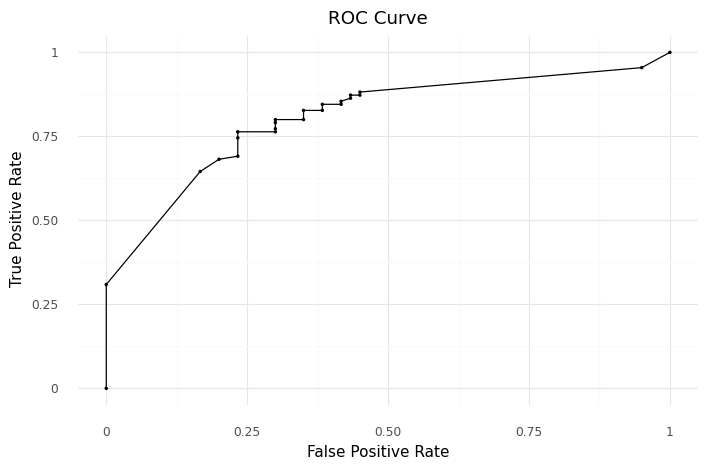

<ggplot: (98369625025)>

In [ ]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 85.0 with G-Mean: 0.7652
FPR: 0.2333, TPR: 0.7636


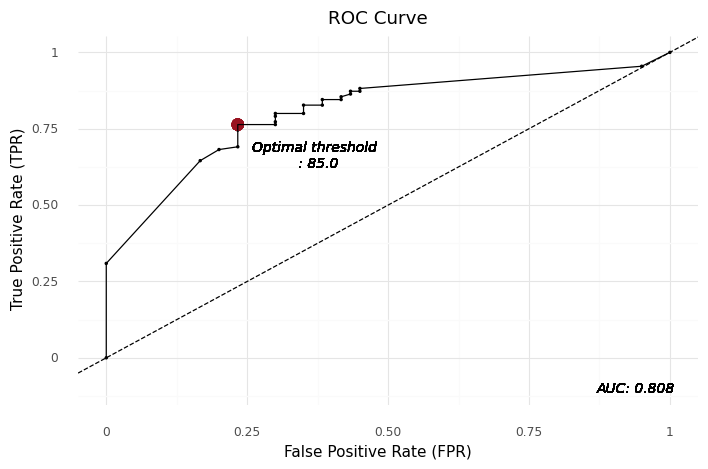

<ggplot: (98361262632)>

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

In [ ]:
# Calculate the Youden's J statistic
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thredholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 85.0 with Youden J statistic: 0.7652
FPR: 0.2333, TPR: 0.7636


NameError: name 'thredholdOpt' is not defined

In [ ]:
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)
roc_auc

0.8080303030303031